In [50]:
from dataclasses import dataclass, replace
import collections
import os
import platform
import pulp
import random
import numpy as np
from collections import deque #, defaultdict

import matplotlib.pyplot as plt
from pyvis.network import Network
from pyvis.options import Layout
from joblib import Parallel, delayed

# Network model

In [51]:
@dataclass
class NetworkParams:
    broadcast_delay_mean: int # second
    pol_proof_time: int # seconds
    # ---- blend network -- 
    blending_delay: int
    dissemination_delay_mean: float
    # desimenation_delay_var: float
    blend_hops: int
    no_network_delay: bool = False

    def sample_blending_delay(self):
        return np.random.uniform(0, self.blending_delay)

    def sample_dissemination_delay(self):
        return np.random.exponential(self.dissemination_delay_mean)

    def sample_blend_network_delay(self):
        return sum(self.sample_blending_delay() + self.sample_dissemination_delay() for _ in range(self.blend_hops))
    
    def sample_broadcast_delay(self, blocks):
        return np.random.exponential(self.broadcast_delay_mean, size=blocks.shape)

    def block_arrival_slot(self, block_slot):
        if self.no_network_delay:
            return block_slot
        return self.pol_proof_time + self.sample_blend_network_delay() + self.sample_broadcast_delay(block_slot) + block_slot

    def empirical_network_delay(self, N=10000, M=1000):
        return np.array([self.block_arrival_slot(np.zeros(M)) for _ in range(N)]).reshape(N*M)

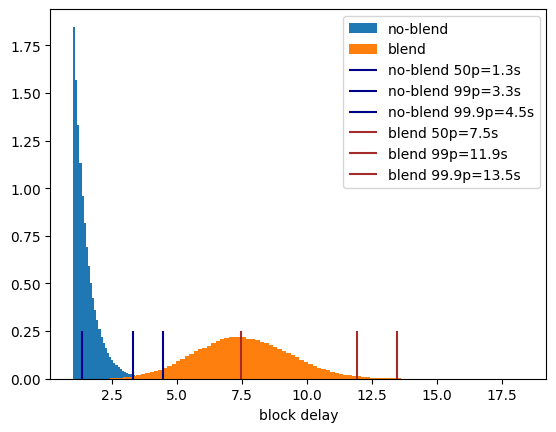

In [52]:
blend_net = NetworkParams(
    broadcast_delay_mean=0.5,
    pol_proof_time=1,
    blending_delay=3,
    dissemination_delay_mean=0.5,
    blend_hops=3,
)
no_blend_net = replace(blend_net, blend_hops=0)

N = 100
M = 10000
no_blend_samples = no_blend_net.empirical_network_delay()
no_blend_mean = no_blend_samples.mean()
blend_samples = blend_net.empirical_network_delay()
blend_mean = blend_samples.mean()

_ = plt.hist(no_blend_samples, bins=100, density=True, label="no-blend")
_ = plt.hist(blend_samples, bins=100, density=True, label="blend")

for p in [50, 99, 99.9]:
    no_blend_pct = np.percentile(no_blend_samples, p)
    _ = plt.vlines(no_blend_pct, ymin=0, ymax=0.25, color='darkblue', label=f"no-blend {p}p={no_blend_pct:.1f}s")

for p in [50, 99, 99.9]:
    blend_pct = np.percentile(blend_samples, p)
    _ = plt.vlines(blend_pct, ymin=0, ymax=0.25, color='brown', label=f"blend {p}p={blend_pct:.1f}s")
# _ = plt.vlines(blend_mean, ymin=0, ymax=1, color='brown', label=f"blend 50p={blend_mean:.1f}s")
# _ = plt.hist(blend_net.block_arrival_slot(np.zeros(1000)), bins=100, density=True, label="blend")
_ = plt.legend()
_ = plt.xlabel("block delay")

# Transaction dependencies (probabilistic models)

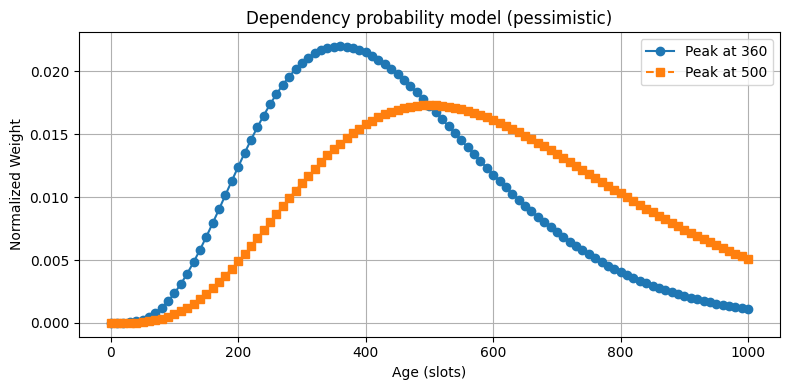

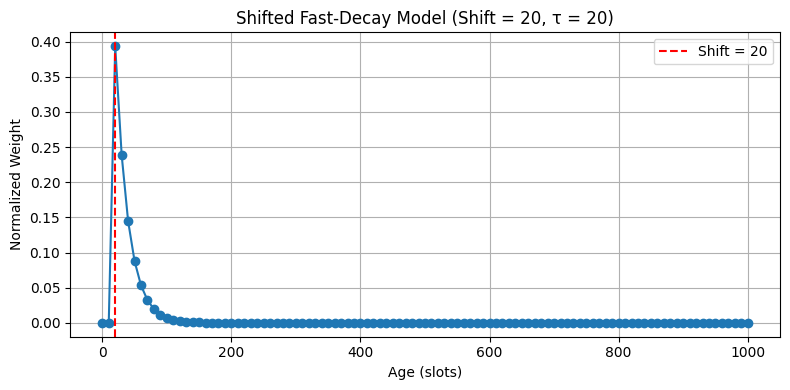

In [53]:
def weights_from_ages(
    ages: np.ndarray,
    peak_age: float = 360.0,
    shape: float = 5.0
) -> np.ndarray:
    # Compute scale parameter so mode = peak_age
    theta = peak_age / (shape - 1)

    # Ensure ages >= 0
    a = np.maximum(ages, 0.0)

    # Compute unnormalized weights: a^(shape-1) * exp(-a/theta)
    w = (a ** (shape - 1)) * np.exp(-a / theta)

    # Zero out negative ages (already clamped, but enforce)
    w[ages < 0] = 0.0

    # Normalize to sum = 1
    total = w.sum()
    if total > 0:
        w /= total
    return w

ages = np.arange(0, 1001, 10)

weights_360 = weights_from_ages(ages, peak_age=360.0, shape=5.0)
weights_500 = weights_from_ages(ages, peak_age=500.0, shape=5.0)

plt.figure(figsize=(8, 4))
plt.plot(ages, weights_360, marker='o', linestyle='-', label='Peak at 360')
plt.plot(ages, weights_500, marker='s', linestyle='--', label='Peak at 500')
plt.xlabel('Age (slots)')
plt.ylabel('Normalized Weight')
plt.title('Dependency probability model (pessimistic)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

def weights_shifted_fast_decay(
    ages: np.ndarray,
    shift: float = 20.0,
    tau:   float = 20.0
) -> np.ndarray:
    w = np.zeros_like(ages, dtype=float)
    # clamp shift so it’s never above ages.max()
    shift_eff = min(shift, ages.max())
    valid = ages >= shift_eff
    a = ages[valid]
    w[valid] = np.exp(-(a - shift_eff) / tau)
    total = w.sum()
    if total > 0:
        w /= total
    return w

# Define ages from 0 to 1000 in steps of 10
ages = np.arange(0, 1001, 10)
weights = weights_shifted_fast_decay(ages, shift=20.0, tau=20.0)

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(ages, weights, marker='o', linestyle='-')
plt.axvline(20, color='red', linestyle='--', label='Shift = 20')
plt.xlabel('Age (slots)')
plt.ylabel('Normalized Weight')
plt.title('Shifted Fast-Decay Model (Shift = 20, τ = 20)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Cryptarchia v2

In [54]:
def phi(f, alpha):
    return 1 - (1-f)**alpha

@dataclass
class Params:
    SLOTS: int
    f: float
    honest_stake: np.array
    adversary_control: float
    window_size: int
    use_deps: bool

    @property
    def N(self):
        return len(self.honest_stake) + 1

    @property
    def stake(self):
        return np.append(self.honest_stake, self.honest_stake.sum() / (1/self.adversary_control - 1))
    
    @property
    def relative_stake(self):
        return self.stake / self.stake.sum()

    def slot_prob(self):
        return phi(self.f, self.relative_stake)

@dataclass
class Block:
    id: int
    slot: int
    refs: list[int]
    deps: list[int]
    leader: int
    adversarial: bool

In [55]:
def visualize_chain(sim):
    layout = Layout()
    layout.hierachical = True

    tooltip_css = """
    <style type="text/css">
    div.vis-tooltip {
        background-color: #f8f8f8;
        border: 1px solid #aaa;
        border-radius: 5px;
        padding: 8px 12px;
        box-shadow: 3px 3px 10px rgba(0,0,0,0.2);
        color: #000;
        font-family: sans-serif;
        font-size: 13px;
        white-space: pre-wrap;
        max-width: 300px;
    }
    </style>
    """
    G = Network(width=1000, height=800, notebook=True, directed=True, layout=layout, cdn_resources='in_line', heading=tooltip_css)
    options_str = """
    {
      "layout": {
        "hierarchical": {
          "enabled": true,
          "levelSeparation": 200,
          "nodeSpacing": 150,
          "treeSpacing": 250,
          "direction": "UD",
          "sortMethod": "directed"
        }
      },
      "physics": {
        "enabled": true,
        "solver": "hierarchicalRepulsion",
        "hierarchicalRepulsion": {
          "centralGravity": 0.0,
          "springLength": 150,
          "springConstant": 0.05,
          "nodeDistance": 150,
          "damping": 0.15
        },
        "stabilization": {
          "enabled": true,
          "iterations": 200000,
          "updateInterval": 2500,
          "onlyDynamicEdges": false,
          "fit": true
        }
      },
      "interaction": {
        "tooltipDelay": 200,
        "hover": true,
        "dragNodes": true,
        "dragView": true,
        "zoomView": true
      },
      "nodes": {
        "font": {
          "size": 14
        },
        "shape": "box",
        "margin": 10
      },
      "edges": {
        "smooth": {
            "enabled": true,
            "type": "cubicBezier",
            "roundness": 0.5
        },
        "arrows": {
          "to": { "enabled": true, "scaleFactor": 0.7 }
        }
      }
    }
    """
    G.set_options(options_str)
    for block in sim.blocks:
        level = block.slot/20 # This puts all the blocks that happen within 20s in the same level (just for visual clarity)
        color = "darkgrey"
        #if block.id in honest_chain_set:
        #    color = "orange"

        if block.adversarial: color = "red"
        G.add_node(int(block.id), level=level, color=color, label=f"(id:{block.id})\ns: {block.slot}\nrefs: {len(block.refs)}")
        # if block.parent >= 0:
        #     G.add_edge(int(block.id), int(block.parent), width=2, color=color)
        # Draw deps first so they are in the background
        # for dep in block.deps:
        #     G.add_edge(int(block.id), int(dep), width=1, color="#dddddd")
        for ref in block.refs:
            G.add_edge(int(block.id), int(ref), width=1, color="blue")

    
    return G.show("chain.html")

In [56]:
def normalize_from_slot(arr: np.ndarray, slot: int) -> np.ndarray:
    """
    Subtract arr[slot] from every element of arr, then clip negatives to zero.
    """
    base = arr[slot]
    adjusted = arr - base
    adjusted[adjusted < 0] = 0
    return adjusted

def longest_advantage_run(a: np.ndarray, b: np.ndarray) -> int:
    """
    Return the length of the longest consecutive run where b >= a,
    using purely NumPy operations.
    """
    mask = b >= a
    # Pad with False at both ends to catch runs at boundaries
    padded = np.concatenate(([False], mask, [False]))
    diff = np.diff(padded.astype(np.int8))
    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0]
    if starts.size == 0:
        return 0
    lengths = ends - starts
    return int(lengths.max())

def highest_advantage_index(a: np.ndarray, b: np.ndarray) -> int:
    """
    Return the largest index i where b[i] >= a[i], or -1 if none exist.
    """
    mask = b >= a
    idxs = np.nonzero(mask)[0]
    return int(idxs[-1]) if idxs.size > 0 else -1

def highest_advantage_index_nonzero(a: np.ndarray, b: np.ndarray) -> int:
    """
    Return the largest index i where b[i] >= a[i] and not (a[i] == 0 and b[i] == 0), 
    or -1 if none exist.
    """
    mask = (b >= a) & ~((a == 0) & (b == 0))
    idxs = np.nonzero(mask)[0]
    return int(idxs[-1]) if idxs.size > 0 else -1


In [57]:
import pulp

def dag_with_max_refs(blocks: list, window_size: int) -> dict[int, list[int]]:
    """
    Returns a dict: block_id -> list of referenced block_ids
    that maximizes the total number of references under these constraints:
    - References go backward in time (from later to earlier blocks)
    - Reference only within `window_size`
    - No transitive references (triangle closure constraint)
    """
    prob = pulp.LpProblem("MaxRefsDAG", pulp.LpMaximize)

    block_ids = [b.id for b in blocks]
    slots = {b.id: b.slot for b in blocks}
    id_set = set(block_ids)

    # Generate all valid candidate pairs (i -> j)
    pairs = [
        (i, j)
        for i in block_ids
        for j in block_ids
        if slots[i] > slots[j] and (slots[i] - slots[j]) <= window_size
    ]

    # Decision variables: x[i][j] = 1 if block i references block j
    x = pulp.LpVariable.dicts("x", pairs, cat="Binary")

    # Objective: maximize total number of references
    prob += pulp.lpSum(x[i, j] for (i, j) in pairs)

    # Triangle constraints: for all i, j, k:
    # if i -> j and j -> k then i must NOT reference k to avoid closure
    # Note that this is a good approximation, but it would allow the adversary simulation to
    # sneak in some extra refs. Since that only could improve our results, this is good enough.
    for i in block_ids:
        for j in block_ids:
            for k in block_ids:
                if (i, j) in x and (j, k) in x and (i, k) in x:
                    prob += x[i, j] + x[j, k] + x[i, k] <= 2

    # Solve the ILP
    solver = pulp.PULP_CBC_CMD(msg=False)
    result = prob.solve(solver)

    if pulp.LpStatus[result] != "Optimal":
        raise RuntimeError("ILP did not find an optimal solution.")

    # Extract result
    ref_graph = {i: [] for i in block_ids}
    for (i, j) in pairs:
        if pulp.value(x[i, j]) > 0.5:
            ref_graph[i].append(j)

    return ref_graph

In [58]:
class Sim:
    def __init__(self, params: Params, network: NetworkParams):
        self.params = params
        self.network = network

        # leaders: fixed-size (N × SLOTS)
        self.leaders = np.zeros((params.N, params.SLOTS), dtype=np.int32)

        # Preallocate capacity for blocks: at most N * SLOTS blocks
        max_blocks = params.N * params.SLOTS
        self.block_slots = np.empty(max_blocks, dtype=np.int32)
        self.block_arrivals = np.empty((params.N, max_blocks), dtype=np.int32)
        self.num_blocks = 0

        self.blocks: list[Block] = []

        # Emit genesis block (id = 0)
        self.emit_block(leader=0, slot=0, refs=[], deps=[])
        # Set arrival times of genesis to 0
        self.block_arrivals[:, 0] = 0

    def clone_for_attack(self):
        new = object.__new__(Sim)
        new.params = self.params
        new.network = self.network

        # Copy leaders array
        new.leaders = self.leaders.copy()

        # Preallocate same sizes
        max_blocks = self.params.N * self.params.SLOTS
        new.block_slots = np.empty_like(self.block_slots)
        new.block_arrivals = np.empty_like(self.block_arrivals)
        new.num_blocks = self.num_blocks

        # Copy blocks list (shallow copy of each Block)
        new.blocks = [
            Block(
                id=b.id,
                leader=b.leader,
                slot=b.slot,
                refs=b.refs.copy(),
                deps=b.deps.copy(),
                adversarial=b.adversarial
            ) for b in self.blocks
        ]

        # Copy underlying arrays
        new.block_slots[: self.num_blocks] = self.block_slots[: self.num_blocks]
        new.block_arrivals[:, : self.num_blocks] = self.block_arrivals[:, : self.num_blocks]

        return new

    def get_seen_blocks_in_window_for_node(self, node_id: int, current_slot: int, window_size: int) -> list[int]:
        if not (0 <= node_id < self.params.N):
            raise ValueError(f"Invalid node_id: {node_id}. Must be between 0 and {self.params.N - 1}.")
        if window_size <= 0:
            raise ValueError(f"window_size must be positive. Got {window_size}.")
        if self.num_blocks == 0:
            return []

        min_slot = current_slot - window_size + 1
        max_slot = current_slot

        arrivals = self.block_arrivals[node_id, : self.num_blocks]
        slots    = self.block_slots[: self.num_blocks]

        mask = (
            (arrivals >= min_slot) & (arrivals <= max_slot) &
            (slots    >= min_slot) & (slots    <= max_slot)
        )
        return np.nonzero(mask)[0].tolist()

    def get_all_blocks_in_window_for_node(self, node_id: int, current_slot: int, window_size: int) -> list[int]:
        if not (0 <= node_id < self.params.N):
            raise ValueError(f"Invalid node_id: {node_id}. Must be between 0 and {self.params.N - 1}.")
        if window_size <= 0:
            raise ValueError(f"window_size must be positive. Got {window_size}.")
        if self.num_blocks == 0:
            return []

        min_slot = current_slot - window_size + 1
        max_slot = current_slot

        slots = self.block_slots[: self.num_blocks]
        mask = (slots >= min_slot) & (slots <= max_slot)
        return np.nonzero(mask)[0].tolist()

    def get_unreachable_blocks(self, node_id: int, current_slot: int) -> list[int]:
        if not (0 <= node_id < self.params.N):
            raise ValueError(f"Invalid node_id: {node_id}. Must be between 0 and {self.params.N - 1}.")

        arrivals = self.block_arrivals[node_id, : self.num_blocks]
        seen_ids = set(np.nonzero(arrivals <= current_slot)[0].tolist())

        has_incoming = set()
        for b in seen_ids:
            for parent in self.blocks[b].refs:
                if parent in seen_ids:
                    has_incoming.add(parent)

        return [b for b in seen_ids if b not in has_incoming]

    def get_max_cardinality_antichain(self, node_id: int, current_slot: int, window: int = None, forbidden: set[int] = None) -> list[int]:
        arrivals = self.block_arrivals[node_id, : self.num_blocks]
        slots_arr = self.block_slots[: self.num_blocks]

        if window is not None:
            min_slot = current_slot - window + 1
            mask = (
                (arrivals <= current_slot) &
                (slots_arr >= min_slot) &
                (slots_arr <= current_slot)
            )
            seen_ids = np.nonzero(mask)[0].tolist()
        else:
            seen_ids = np.nonzero(arrivals <= current_slot)[0].tolist()

        # Filter out any forbidden blocks right away
        if forbidden is not None:
            seen_ids = [i for i in seen_ids if i not in forbidden]
        
        if not seen_ids:
            return []

        idx = {blk_id: i for i, blk_id in enumerate(seen_ids)}
        n = len(seen_ids)

        adj_children = {b: [] for b in seen_ids}
        for b in seen_ids:
            for parent in self.blocks[b].refs:
                if parent in idx:
                    adj_children[parent].append(b)

        graph: list[list[int]] = [[] for _ in range(n)]
        for u in seen_ids:
            u_idx = idx[u]
            visited = set()
            stack = adj_children[u].copy()
            while stack:
                x = stack.pop()
                if x not in visited:
                    visited.add(x)
                    stack.extend(adj_children.get(x, []))
            graph[u_idx] = [idx[v] for v in visited]

        pair_u = [-1] * n
        pair_v = [-1] * n
        dist   = [0]  * n

        def bfs():
            queue = deque()
            found_augment = False
            for u in range(n):
                if pair_u[u] == -1:
                    dist[u] = 0
                    queue.append(u)
                else:
                    dist[u] = float("inf")
            while queue:
                u = queue.popleft()
                for v_idx in graph[u]:
                    pu = pair_v[v_idx]
                    if pu != -1 and dist[pu] == float("inf"):
                        dist[pu] = dist[u] + 1
                        queue.append(pu)
                    if pu == -1:
                        found_augment = True
            return found_augment

        def dfs(u):
            for v_idx in graph[u]:
                pu = pair_v[v_idx]
                if pu == -1 or (dist[pu] == dist[u] + 1 and dfs(pu)):
                    pair_u[u] = v_idx
                    pair_v[v_idx] = u
                    return True
            dist[u] = float("inf")
            return False

        while bfs():
            for u in range(n):
                if pair_u[u] == -1 and dfs(u):
                    pass

        visited_u = [False] * n
        visited_v = [False] * n
        queue = deque(u for u in range(n) if pair_u[u] == -1)
        while queue:
            u = queue.popleft()
            if visited_u[u]:
                continue
            visited_u[u] = True
            for v_idx in graph[u]:
                if not visited_v[v_idx]:
                    visited_v[v_idx] = True
                    pu = pair_v[v_idx]
                    if pu != -1 and not visited_u[pu]:
                        queue.append(pu)

        return [
            blk_id
            for blk_id, u_idx in idx.items()
            if visited_u[u_idx] and not visited_v[u_idx]
        ]

    def emit_block(self, leader, slot, refs, deps, adversarial=False):
        assert isinstance(leader, (int, np.int64))
        assert isinstance(slot, (int, np.int64))
        assert all(isinstance(r, (int, np.int64)) for r in refs)

        block = Block(
            id=self.num_blocks,
            leader=leader,
            slot=slot,
            refs=refs.copy(),
            deps=deps.copy(),
            adversarial=adversarial
        )
        self.blocks.append(block)

        self.block_slots[self.num_blocks] = slot

        if not adversarial:
            base = np.repeat(slot, self.params.N)
            arrival = self.network.block_arrival_slot(base)
        else:
            arrival = np.full((self.params.N,), self.params.SLOTS - 1, dtype=np.int64)
            arrival[self.params.N - 1] = slot

        self.block_arrivals[:, self.num_blocks] = arrival

        bid = self.num_blocks
        self.num_blocks += 1
        return bid

    def emit_leader_block(self, leader, slot):
        assert isinstance(leader, (int, np.int64))
        assert isinstance(slot, int)

        arrivals = self.block_arrivals[leader, : self.num_blocks]
        seen_ids = np.nonzero(arrivals <= slot)[0].tolist()

        deps = []
        if seen_ids:
            seen_slots = [self.block_slots[i] for i in seen_ids]
            ages = [slot - s for s in seen_slots]
            weights = weights_from_ages(np.array(ages), peak_age=60.0, shape=5.0)
            dep = random.choices(seen_ids, weights=weights, k=1)[0]
            deps = [int(dep)]

        refs = self.get_max_cardinality_antichain(leader, slot, window=self.params.window_size)
        # print(f"slot: {slot}, refs: {refs}")

        emitted = self.emit_block(leader, slot, refs=refs, deps=deps)

        unreachable = self.get_unreachable_blocks(leader, slot)
        unreachable = [
            b for b in unreachable
            if b != emitted and (slot - self.blocks[b].slot) >= self.params.window_size
        ]

        if unreachable:
            self.blocks[emitted].refs.append(random.choice(unreachable))

        return emitted

    def run(self):
        for s in range(1, self.params.SLOTS):
            self.leaders[:, s] = np.random.random(size=self.params.N) < self.params.slot_prob()
            for leader in np.nonzero(self.leaders[:, s])[0]:
                if self.params.adversary_control is not None and leader == self.params.N - 1:
                    continue
                self.emit_leader_block(leader, s)

    def compute_descendants(self, start_block):
        start_id = start_block.id if hasattr(start_block, "id") else start_block

        children = {i: [] for i in range(len(self.blocks))}
        for i, blk in enumerate(self.blocks):
            parents = blk.refs if self.params.use_deps else blk.refs
            for r in parents:
                children[r].append(i)

        desc = {start_id}
        queue = collections.deque([start_id])
        while queue:
            cur = queue.popleft()
            for child in children[cur]:
                if child not in desc:
                    desc.add(child)
                    queue.append(child)
        desc.remove(start_id)
        return desc

    def block_ref_weights_by_slot(self, start_id: int) -> np.ndarray:
        descendants = self.compute_descendants(start_id)
        weights_by_slot = np.zeros(self.params.SLOTS, dtype=np.int64)
        window = self.params.window_size
        for did in descendants:
            did_slot = self.blocks[did].slot
            refs = self.blocks[did].refs
            count = sum(
                1
                for r in refs
                if did_slot - self.blocks[r].slot < window
            )
            weights_by_slot[did_slot] += count
        return np.cumsum(weights_by_slot)

    def adversarial_ref_weights_by_slot(self, start_id: int) -> np.ndarray:
        descendants = self.compute_descendants(start_id)
        adv_desc = [d for d in descendants if self.blocks[d].adversarial]
        weights_by_slot = np.zeros(self.params.SLOTS, dtype=np.int64)
        window = self.params.window_size
        for did in adv_desc:
            did_slot = self.blocks[did].slot
            refs = self.blocks[did].refs
            count = sum(
                1
                for r in refs
                if did_slot - self.blocks[r].slot < window
            )
            weights_by_slot[did_slot] += count
        return np.cumsum(weights_by_slot)

    def attack_on_block(self, target_block: Block):
        """Just a wrapper to easily choose the attack computation technique"""
        return self.attack_on_block_global_greedy(target_block)
    
    def attack_on_block_sliding_ILP(self, target_block: Block):
        """
        Attack on a specific block. The provided block is the closest ancestor of a honest block on which
        the attacker wants to introduce a conflict and win. Since the conflict resolution rules operate on
        the closest common ancestor of those two conflicting blocks, we perform the attack by exhaustively
        exploring every possible starting block.

        We are returning the reorg measured as from the attacked block (common ancestor) up to the last
        adversarial block. This makes it imprecise, but in a DAG there is no perfect measure of "reorg 
        length". In any case, this is only relevant for "full reorg" counting, which is fine to compute
        approximately giving some tolearance value to the definition of "full reorg".
        """
        adv = self.params.N - 1
        fid = target_block.id
        fslot = target_block.slot

        # Static forbidden = all descendants of fid (and fid itself)
        forbidden = set(self.compute_descendants(fid)) | {fid}

        # Precompute adversarial slots after fslot
        adv_slots = list(np.flatnonzero(self.leaders[adv, fslot + 1 :]) + fslot + 1)
        if not adv_slots:
            return -1

        # Pre‐emit every adversarial block at its slot, chaining deps (optimal), empty refs for now
        adversarial_block_ids = []
        prev_bid = None
        for slot in adv_slots:
            deps = [] if prev_bid is None else [prev_bid]
            bid = self.emit_block(adv, slot, refs=[], deps=deps, adversarial=True)
            adversarial_block_ids.append(bid)
            prev_bid = bid

        first_adv_block = self.blocks[adversarial_block_ids[0]]
        first_adv_block.refs = self.get_max_cardinality_antichain(adv, first_adv_block.slot, window=self.params.window_size)
        
        #for fixed_i in range(len(adversarial_block_ids) - 1, -1, -1):
        for fixed_i in range(1, len(adversarial_block_ids)-1):
            fixed_adv = self.blocks[adversarial_block_ids[fixed_i]]
            candidate_blocks = [
                self.blocks[i] 
                for i in self.get_all_blocks_in_window_for_node(
                    adv, 
                    fixed_adv.slot, 
                    self.params.window_size * 2
                ) 
                if self.blocks[i].id not in forbidden
            ]
            best_dag = dag_with_max_refs(candidate_blocks, self.params.window_size)
            fixed_adv.refs = best_dag[fixed_adv.id]

        # Extra pass (ensure full connectivity + rule 2)
        # For every adversarial block, add extra references to disconnected
        # They won't count if outside the window, but 
        for i, a in reversed(list(enumerate(adversarial_block_ids))):
            a_slot = self.blocks[a].slot
            desc_set = self.compute_descendants(a)
            for b in adversarial_block_ids[i + 1:]:
                b_slot = self.blocks[b].slot
                if ( b not in desc_set and not self.blocks[b].refs
                    #b not in desc_set and
                    #not self.blocks[b].refs and
                    #(b_slot - a_slot) >= self.params.window_size  # must be outside the window
                ):
                    self.blocks[b].refs.append(a)
                    #break

        # Find the slot of the closest direct honest descendant of fid
        # This is the block with the conflict that will be replaced by the adversary
        ref_slot = None
        for b in self.blocks[target_block.id+1:]:
            if b.adversarial: # all adversarial blocks are at the end
                break
            if target_block.id in b.refs:
                ref_slot = b.slot
                break
        if ref_slot is None:
            return -1

        # Compute reorg length, capping at last adversarial slot
        last_adv_slot = self.blocks[adversarial_block_ids[-1]].slot
        first_adv_bid = adversarial_block_ids[0]
        honest_weights = self.block_ref_weights_by_slot(fid)
        adv_weights = self.adversarial_ref_weights_by_slot(first_adv_bid)

        # We are returning the reorg measured as from the attacked block (common ancestor)
        # up to the last adversarial block. This makes it imprecise, but in a DAG there is no
        # perfect measure of "reorg length".
        hi_uncapped = highest_advantage_index_nonzero(honest_weights, adv_weights)
        hi = min(hi_uncapped, last_adv_slot)
        return int(hi - ref_slot) if hi - ref_slot >= 0 else -1

    def attack_on_block_global_greedy(self, target_block: Block):
        """
        Attack on a specific block using an optimized antichain building strategy.
        Going back to the version that actually worked!
        """
        adv = self.params.N - 1
        fid = target_block.id
        fslot = target_block.slot
    
        # Static forbidden = all descendants of fid (and fid itself)
        forbidden = set(self.compute_descendants(fid)) | {fid}
    
        # Precompute adversarial slots after fslot
        adv_slots = list(np.flatnonzero(self.leaders[adv, fslot + 1 :]) + fslot + 1)
        if not adv_slots:
            return -1
    
        # Pre-emit every adversarial block at its slot, chaining deps (optimal), empty refs for now
        adversarial_block_ids = []
        prev_bid = None
        for slot in adv_slots:
            deps = [] if prev_bid is None else [prev_bid]
            bid = self.emit_block(adv, slot, refs=[], deps=deps, adversarial=True)
            adversarial_block_ids.append(bid)
            prev_bid = bid
    
        def compute_closure_refs_only(block_id):
            """Compute transitive closure following only refs, not deps"""
            closure = set()
            stack = [block_id]
            while stack:
                current = stack.pop()
                if current not in closure:
                    closure.add(current)
                    if current in adversarial_block_ids:
                        stack.extend(self.blocks[current].refs)
            return closure
    
        def compute_descendants_refs_only(start_id):
            """Compute descendants following only refs (for Rule 2 connectivity check)"""
            descendants = set()
            stack = [start_id]
            while stack:
                current = stack.pop()
                if current not in descendants:
                    descendants.add(current)
                    if current in adversarial_block_ids:
                        stack.extend(self.blocks[current].refs)
            descendants.discard(start_id)
            return descendants
    
        def build_maximum_antichain(candidates):
            """
            Build a maximum antichain from the candidate blocks.
            Key insight: we only care about refs for transitivity, not deps!
            """
            if not candidates:
                return []
            
            # Build reachability matrix based on refs only (not deps!)
            n = len(candidates)
            reachable = np.zeros((n, n), dtype=bool)
            
            # Build reachability through refs only
            for i, block_i in enumerate(candidates):
                # Compute what's reachable from block_i through refs
                visited = set()
                stack = [block_i]
                while stack:
                    current = stack.pop()
                    if current not in visited:
                        visited.add(current)
                        # Only follow refs, not deps!
                        if current in adversarial_block_ids:
                            stack.extend(self.blocks[current].refs)
                
                # Mark reachability
                for j, block_j in enumerate(candidates):
                    if i != j and block_j in visited:
                        reachable[i][j] = True
            
            # Now build antichain greedily with smart ordering
            # Sort candidates by strategy:
            # 1. Prefer blocks with fewer reachable blocks (less constraining)
            # 2. Then by slot (prefer more recent for weight)
            candidate_scores = []
            for i, bid in enumerate(candidates):
                reachable_count = np.sum(reachable[i, :])  # How many blocks this reaches
                reached_by_count = np.sum(reachable[:, i])  # How many blocks reach this
                slot = self.blocks[bid].slot
                # Score: prefer blocks that reach few and aren't reached by many
                score = (-reachable_count * 1000 - reached_by_count * 100 + slot)
                candidate_scores.append((i, bid, score))
            
            candidate_scores.sort(key=lambda x: x[2], reverse=True)
            
            # Build antichain greedily
            antichain = []
            antichain_indices = []
            
            for i, bid, score in candidate_scores:
                # Check if this block is compatible with current antichain
                can_add = True
                
                for j in antichain_indices:
                    # Can't add if there's a path between them in either direction
                    if reachable[i][j] or reachable[j][i]:
                        can_add = False
                        break
                
                if can_add:
                    antichain.append(bid)
                    antichain_indices.append(i)
            
            return antichain
    
        # Build optimal antichain for each adversarial block
        for idx, adv_bid in enumerate(adversarial_block_ids):
            adv_block = self.blocks[adv_bid]
            
            # Get candidates: all previous adversarial blocks within window
            candidates = []
            min_slot = max(0, adv_block.slot - self.params.window_size)
            
            for earlier_idx in range(idx):
                earlier_bid = adversarial_block_ids[earlier_idx]
                earlier_block = self.blocks[earlier_bid]
                
                if earlier_block.slot >= min_slot and earlier_block.slot < adv_block.slot:
                    candidates.append(earlier_bid)
            
            # Build the antichain using the reachability matrix approach
            refs = build_maximum_antichain(candidates)
            adv_block.refs = refs
    
        # Extra pass (ensure full connectivity + rule 2)
        for i, a in reversed(list(enumerate(adversarial_block_ids))):
            desc_set = compute_descendants_refs_only(a)
            for b in adversarial_block_ids[i + 1:]:
                if b not in desc_set and not self.blocks[b].refs:
                    self.blocks[b].refs.append(a)
    
        # Find the slot of the closest direct honest descendant of fid
        ref_slot = None
        for b in self.blocks[target_block.id+1:]:
            if b.adversarial:
                break
            if target_block.id in b.refs:
                ref_slot = b.slot
                break
        if ref_slot is None:
            return -1
    
        # Compute reorg length
        last_adv_slot = self.blocks[adversarial_block_ids[-1]].slot
        first_adv_bid = adversarial_block_ids[0]
        honest_weights = self.block_ref_weights_by_slot(fid)
        adv_weights = self.adversarial_ref_weights_by_slot(first_adv_bid)
    
        hi_uncapped = highest_advantage_index_nonzero(honest_weights, adv_weights)
        hi = min(hi_uncapped, last_adv_slot)
        return int(hi - ref_slot) if hi - ref_slot >= 0 else -1

## Single Run and Visualization

In [59]:
%%time
random.seed(0)
np.random.seed(0)

sim = Sim(
    params=Params(
        SLOTS=1000,
        f=0.25,
        window_size=30,
        use_deps=True,
        adversary_control = 0.4,
        honest_stake = np.random.pareto(10, 1000)
    ),
    network=blend_net
)
sim.run()

n_blocks_per_slot = len(sim.blocks) / sim.params.SLOTS
print("avg blocks per slot", n_blocks_per_slot)
print("Number of blocks", len(sim.blocks))

total_refs = sum([len(b.refs) for b in sim.blocks])
print("Total number of refs created", total_refs)

avg blocks per slot 0.159
Number of blocks 159
Total number of refs created 399
CPU times: user 34 ms, sys: 3.81 ms, total: 37.8 ms
Wall time: 37.4 ms


In [60]:
max_reorg = sim.attack_on_block(sim.blocks[3])
print("reorg:", max_reorg)

visualize_chain(sim)

reorg: 61
chain.html


## Attack all blocks (single-threaded)

In [61]:
# def attack_all_blocks(sim) -> dict[int, any]:
#     sim.run()
#     baseline = sim.clone_for_attack()

#     results: dict[int, any] = {}
#     adv_id = baseline.params.N - 1
#     for blk in baseline.blocks:
#         if blk.leader == adv_id:
#             continue
#         sim_copy = baseline.clone_for_attack()
#         results[blk.id] = sim_copy.attack_on_block(sim_copy.blocks[blk.id])
#     return results

# random.seed(0)
# np.random.seed(0)

# sim = Sim(
#     params=Params(
#         SLOTS=1000,
#         f=0.25,
#         window_size=30,
#         use_deps=True,
#         adversary_control = 0.4,
#         honest_stake = np.random.pareto(10, 1000)
#     ),
#     network=blend_net
# )

# results = attack_all_blocks(sim)
# print("(ID, reorg length) -> ", max(results.items(), key=lambda x: x[1]))

## Attack all blocks (parallelized)

In [62]:
import os
import platform

home_dir = os.path.expanduser("~")
joblib_temp = os.path.join(home_dir, "joblib_tmp")

def parallel_attack_all_blocks(sim, skip_last: int = 0):
    sim.run()

    def _attack_block_copy(orig_sim, block_id):
        sim_copy = orig_sim.clone_for_attack()
        result = sim_copy.attack_on_block(sim_copy.blocks[block_id])
        return block_id, result

    # Configuration for the Nomos experiments server
    n_jobs = 95 if platform.system() == "Linux" else 8
    
    blocks = sim.blocks if skip_last == 0 else sim.blocks[:-skip_last]
    block_ids = [b.id for b in blocks]
    attacked_results = Parallel(
        n_jobs=n_jobs,
        backend="loky",
        temp_folder=joblib_temp
    )(
        delayed(_attack_block_copy)(sim, bid)
        for bid in block_ids
    )
    return (attacked_results, sim.blocks)

def plot_attack_histogram_binned(attacked_results, bin_size=30, figsize=(12, 6), label_fontsize=8):
    indices = [result for _, result in attacked_results]
    max_idx = max(indices)
    
    bin_start = 0
    bin_end = ((max_idx // bin_size) + 1) * bin_size
    bins = list(range(bin_start, bin_end + bin_size, bin_size))
    
    labels = [f"{b // bin_size} ({b})" for b in bins]
    
    plt.figure(figsize=figsize)
    plt.hist(indices, bins=bins, edgecolor='black')
    plt.xlabel('Reorg in virtual blocks and slots')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Attack Results (bins of {bin_size})')
    plt.xticks(bins, labels, rotation='vertical', fontsize=label_fontsize)
    plt.tight_layout()
    plt.show()

In [63]:
# %%time
# random.seed(0)
# np.random.seed(0)

# sim = Sim(
#     params=Params(
#         SLOTS=15000,
#         f=0.25,
#         window_size=30,
#         use_deps=True,
#         adversary_control = 0.3,
#         honest_stake = np.random.pareto(10, 1000)
#     ),
#     network=blend_net
# )
# attack_result = parallel_attack_all_blocks(sim)
# plot_attack_histogram_binned(attack_result, bin_size=30)

# print(max(attack_result, key=lambda x: x[1]))

## Multiple Experiments and frequency analysis

In [64]:
def plot_attack_histogram_frequency(
    attacked_results: list[tuple[int, int]],
    total_honest_blocks: int,
    adversary_stake: int,
    bin_size: int = 30,
    figsize: tuple[int, int] = (12, 6),
    label_fontsize: int = 8,
    file_suffix=""
):
    # Extract reorg lengths from (block_id, length) tuples
    all_reorgs = [length for _, length in attacked_results if length > 0]
    if not all_reorgs:
        print("No reorgs to plot")
        return
    
    # Compute bins
    max_idx = max(all_reorgs)
    bin_end = ((max_idx // bin_size) + 1) * bin_size
    bins = np.arange(0, bin_end + bin_size, bin_size)

    # Compute weights (relative frequencies) for histogram
    weights = np.ones_like(all_reorgs, dtype=float) / total_honest_blocks
    counts, edges = np.histogram(all_reorgs, bins=bins, weights=weights)

    plt.figure(figsize=figsize)

    # Bar plot with a muted blue and slight transparency
    bars = plt.bar(
        edges[:-1],
        counts,
        width=bin_size,
        align='edge',
        edgecolor='#555555',
        color='#4C72B0',
        alpha=0.8,
        label='Grouped relative frequency (virtual blocks)'
    )

    # Compute exact relative frequency (no bins)
    unique_vals, raw_counts = np.unique(all_reorgs, return_counts=True)
    exact_rel_freq = raw_counts / total_honest_blocks

    # Line plot of exact relative frequencies with a contrasting orange and thinner line
    plt.plot(
        unique_vals,
        exact_rel_freq,
        marker='o',
        markersize=4,
        linestyle='-',
        color='#DD8452',
        linewidth=1.0,
        label='Relative frequency per slot'
    )

    plt.yscale('log')
    plt.xlabel('Reorg in virtual blocks and slots')
    plt.ylabel('Relative frequency (log scale)')
    plt.title(f'Log‐Scaled Histogram over {total_honest_blocks} Honest Blocks ({ADVERSARY_STAKE * 100}% adversarial stake)')

    # Annotate bars
    for bar, height in zip(bars, counts):
        if height > 0:
            x = bar.get_x() + bar.get_width() / 2
            y = height
            plt.text(
                x,
                y,
                f'{height:.2e}',
                ha='center',
                va='bottom',
                fontsize=label_fontsize
            )

    plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.3)
    plt.xticks(
        edges,
        [f"{int(edge // bin_size)} ({int(edge)})" for edge in edges],
        rotation='vertical',
        fontsize=label_fontsize
    )
    plt.legend(fontsize=label_fontsize)
    plt.tight_layout()
    plt.savefig(f'simulation_results_histogram{file_suffix}.png', dpi=300, bbox_inches='tight')
    plt.show()

def fully_successful_attacks(
    attacked_results: list[tuple[int, int]],
    sim: Sim,
    tolerance: int = 0
) -> int:
    """
    Count how many attacks were “fully successful,” meaning
    reorg_length ≥ ( (S−1) − fslot ) − tolerance,
    where fslot is the honest block’s slot.

    Read the attack_on_block function for more details
    """
    S = sim.params.SLOTS
    count = 0

    successful = []
    for honest_id, length in attacked_results:
        if length < 0:
            continue

        fslot = sim.blocks[honest_id].slot
        max_len = (S - 1) - fslot
        if length >= max_len - tolerance:
            successful.append([honest_id, fslot, length])
            count += 1

    return count, successful

In [65]:
def run_multiple_attacks(
    n_runs: int,
    slots: int,
    f: float,
    window_size: int,
    use_deps: bool,
    adversary_control: float,
    network,
    base_seed: int = 0,
    skip_last: int = 100,
) -> tuple[list[int], int]:
    """
    Runs `parallel_attack_all_blocks` over `n_runs` independent seeds.
    Returns:
      - all_attacks: flattened list of (block_id, reorg_length) tuples
      - total_honest_blocks: count of honest blocks across all runs
      - last_sim: the Sim instance from the final run
    """
    assert slots > 500, "Must simulate more than 500 slots"
    all_attacks: list[tuple[int, int]] = []
    total_honest_blocks = 0
    last_sim = None

    for i in range(n_runs):
        print(f"Executing run {i + 1}/{n_runs}")
        seed = base_seed + i
        random.seed(seed)
        np.random.seed(seed)

        params = Params(
            SLOTS=slots,
            f=f,
            window_size=window_size,
            use_deps=use_deps,
            adversary_control=adversary_control,
            honest_stake=np.random.pareto(10, 1000)
        )
        sim = Sim(params=params, network=network)
        last_sim = sim   # save for return

        attacked, blocks = parallel_attack_all_blocks(sim, skip_last=skip_last)
        all_attacks.extend(attacked)

        total_honest_blocks += len(blocks)-skip_last

        # Print at every step
        plot_attack_histogram_frequency(all_attacks, total_honest_blocks, adversary_control, bin_size=30, file_suffix=f"_{i}")

    return all_attacks, total_honest_blocks, last_sim

Executing run 1/1


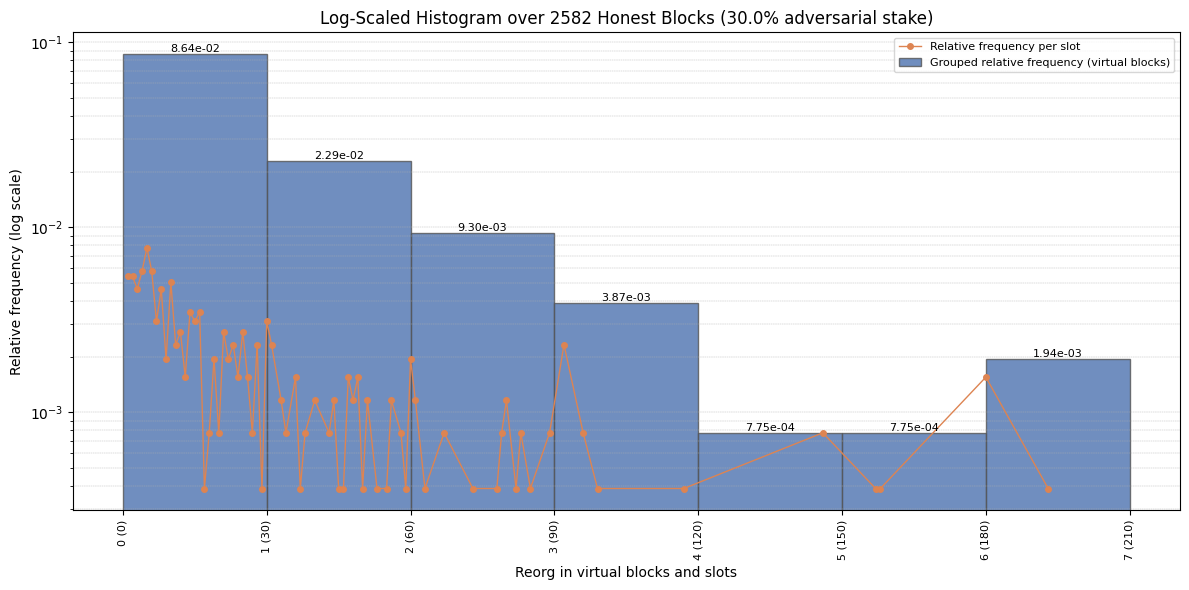

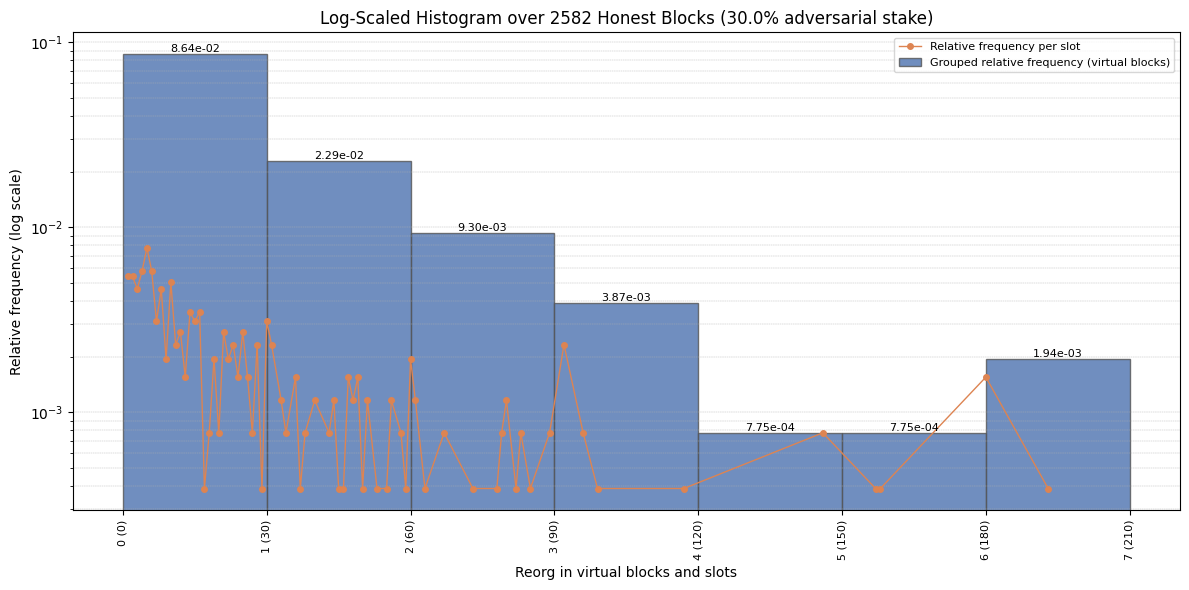

Largest reorg length: 193 (~6 virtual blocks of 30-seconds)
Successful attacks: 0 (0.00%)
Successful attacks list [target block, target slot, reorg length]): []
CPU times: user 33.3 s, sys: 13.2 s, total: 46.4 s
Wall time: 1min 28s


In [66]:
%%time

ADVERSARY_STAKE = 0.30
# Run multiple experiments
attacked_results, total_blocks, sim = run_multiple_attacks(
    n_runs=1,
    slots=15000,
    f=0.25,
    window_size=30,
    use_deps=True,
    adversary_control=ADVERSARY_STAKE,
    network=blend_net,
    base_seed=0,
    # these are honest blocks that won't be attacked and will not count in the stats, but give room for the attack.
    skip_last=500
)

# Plot normalized histogram:
plot_attack_histogram_frequency(attacked_results, total_blocks, ADVERSARY_STAKE, bin_size=30)

# Print the most extreme reorg seen:
reorg_lengths = [length for _, length in attacked_results]
max_length = max(reorg_lengths) if reorg_lengths else 0
print(f"Largest reorg length: {max_length} (~{(max_length // 30)} virtual blocks of 30-seconds)")

fully = fully_successful_attacks(attacked_results, sim, tolerance=500) # Very generous tolerance
print(f"Successful attacks: {fully[0]} ({fully[0]/total_blocks*100:.2f}%)")
print(f"Successful attacks list [target block, target slot, reorg length]): {fully[1]}")